### Introduction
I noticed that reddit being the expansive website that it is has subreddits for each of the Meyers Briggs personality types. I thought it would be interesting to see some of the differences between population data and the reddit data.

In [1]:
import pandas as pd
import itertools
import praw
import json
import datetime as DT

In [2]:
# Create list of personality types
dichotomies = [('E', 'I'), ('N', 'S'), ('T', 'F'), ('P', 'J')]
personality_types_tuples = list(itertools.product(*dichotomies))
personality_types = [''.join(pt_tuple) for pt_tuple in personality_types_tuples]

In [3]:
# Get HTML Table
pt_dist_url = 'https://www.careerplanner.com/MB2/TypeInPopulation.cfm'
pt_dist_df = pd.read_html(pt_dist_url)
pt_dist_df = pt_dist_df[-1]

# Properly construct the DataFrame
pt_dist_df[2][0] = pt_dist_df[1][0]
del pt_dist_df[1]
pt_dist_df = pt_dist_df.iloc[1:]
pt_dist_df.columns = ['type', 'pop_freq']
pt_dist_df = pt_dist_df.set_index('type')

# Convert string percentage to numeric
pt_dist_df['pop_freq'] = pd.to_numeric(pt_dist_df['pop_freq'].str.strip('%'))/100

In [4]:
# Get authentication information
with open('authentication.json') as file:
    auth = json.load(file)

reddit = praw.Reddit(client_id=auth['client_id'], client_secret=auth['client_secret'],
                     password=auth['password'], user_agent=auth['user_agent'],
                     username=auth['username'])

# Create Reddit DataFrame
pt_sr_info_df_columns = ['display_name', 'created_utc', 'description', 'name', 'subscribers', 'gilded']
pt_sr_info_df = pd.DataFrame(columns=pt_sr_info_df_columns, index=personality_types)
pt_sr_info_df.index.name = 'ptypes'
for ptype in personality_types:
    sr_name = reddit.subreddit(ptype).name

    sr_info = next(reddit.info([sr_name]))
    sr_info_vars = vars(sr_info)
    ptype_row = []
    for col in pt_sr_info_df.columns[:-1]:
        ptype_row.append(sr_info_vars[col])

    gilded_count = sum(1 for i in reddit.subreddit(ptype).gilded())
    ptype_row.append(gilded_count)

    pt_sr_info_df.loc[ptype] = ptype_row
    

In [19]:
# Concatenating the data
df = pd.concat([pt_sr_info_df, pt_dist_df], axis=1)

# Feature engineering
df['description_length'] = df.description.apply(len)
df['creation_date'] = pd.to_datetime(df.created_utc, unit='s')
df['age'] = pd.Timestamp(DT.datetime.now()) - df.creation_date

In [24]:
print(df['index'])

KeyError: 'index'

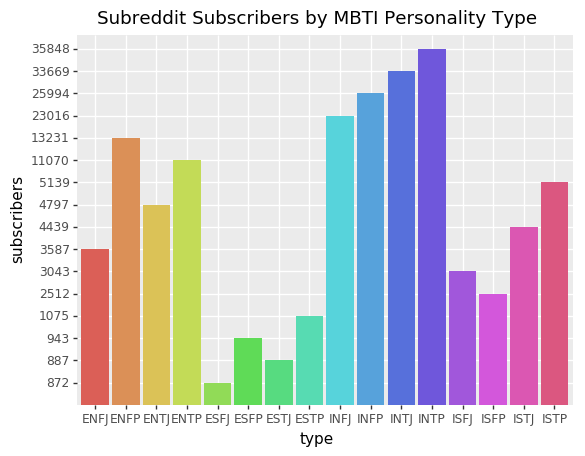

<ggplot: (103456600233)>

In [42]:
from plotnine import *
(ggplot(df) +
    aes(x='type', y='subscribers', fill='type') +
    geom_bar(stat="identity") +
    guides(fill=False) +
    ggtitle('Subreddit Subscribers by MBTI Personality Type'))

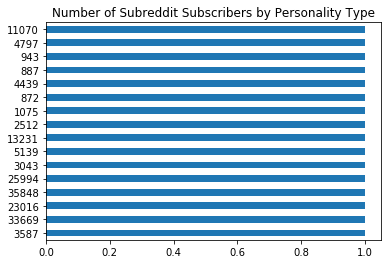